# PCA of multiple molecules

## Isoelectronics: ethene and methylene immonium

In [1]:
import matplotlib.pyplot as plt
import xarray as xr

import shnitsel as sh
import shnitsel.xarray

In [2]:
a01 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C2H4.nc')
i01 = sh.open_frames('/nc/SHNITSEL_databases/dynamic/I01_ch2nh2_dynamic.nc')

In [3]:
i01.sh.expand_midx('frame', 'cmpnd', 'i01')

<xarray.Dataset> Size: 49MB
Dimensions:    (state: 3, frame: 39365, direction: 3, statecomb: 3, atom: 6,
                state2: 3, trajid_: 200)
Coordinates: (12/13)
  * state      (state) int64 24B 1 2 3
  * state2     (state2) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
    atNames    (atom) <U1 24B ...
  * trajid_    (trajid_) int32 800B 2 6 9 21 25 29 ... 920 924 929 938 943 947
    ...         ...
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
  * frame      (frame) object 315kB MultiIndex
  * cmpnd      (frame) object 315kB 'i01' 'i01' 'i01' ... 'i01' 'i01' 'i01'
  * trajid     (frame) int64 315kB 2 2 2 2 2 2 2 ... 947 947 947 947 947 947 947
  * time       (frame) float64 315kB 0.0 0.5 1.0 1.5 ... 98.5 99.0 99.5 100.0
Data variables:
    energy     (state, frame) float64 945kB ...
    dip_perm   (state, direction, frame) float64 3MB ...
    dip_trans  (statecomb, direction, frame) float64 3MB ...
    sdiag      (frame) int64 315kB ...
    astate     (frame) int64 315kB ...
    forces     (state, atom, direction, frame) float64 17MB ...
    phases     (state, frame) float64 945kB ...
    nacs       (statecomb, atom, direction, frame) float64 17MB ...
    atXYZ      (atom, direction, frame) float64 6MB ...
    max_ts     (trajid_) int32 800B ...
    completed  (trajid_) int8 200B ...
    nsteps     (trajid_) int32 800B ...
Attributes:
    delta_t:  0.5

In [4]:
isoelec = xr.concat(
    [
        a01.sh.expand_midx('frame', 'cmpnd', 'a01'),
        i01.sh.expand_midx('frame', 'cmpnd', 'i01')
    ],
    dim='frame'
)
isoelec

<xarray.Dataset> Size: 1GB
Dimensions:    (state: 3, frame: 101396, direction: 3, statecomb: 3, atom: 6,
                trajid_: 431, state2: 3)
Coordinates: (12/13)
  * state      (state) int64 24B 1 2 3
  * state2     (state2) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
  * trajid_    (trajid_) int32 2kB 2 3 4 6 8 9 10 ... 950 951 956 957 961 962
  * statecomb  (statecomb) object 24B MultiIndex
    ...         ...
  * to         (statecomb) int64 24B 2 3 3
  * frame      (frame) object 811kB MultiIndex
  * cmpnd      (frame) object 811kB 'a01' 'a01' 'a01' ... 'i01' 'i01' 'i01'
  * trajid     (frame) int64 811kB 2 2 2 2 2 2 2 ... 947 947 947 947 947 947 947
  * time       (frame) float64 811kB 0.0 0.5 1.0 1.5 ... 98.5 99.0 99.5 100.0
    atNames    (frame, atom) <U1 2MB 'C' 'C' 'H' 'H' 'H' ... 'N' 'H' 'H' 'H' 'H'
Data variables: (12/13)
    energy     (state, frame) float64 2MB 0.8285 0.6196 0.3822 ... 11.89 12.12
    e_kin      (frame) float64 811kB 0.1839 0.4249 0.7293 0.9647 ... nan nan nan
    dip_perm   (state, direction, frame) float64 7MB 0.005891 0.005083 ... 1.512
    dip_trans  (statecomb, direction, frame) float64 7MB -1.421 ... 0.5138
    sdiag      (frame) int64 811kB 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1
    astate     (frame) int64 811kB 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1
    ...         ...
    phases     (state, frame) float64 2MB -1.0 1.0 1.0 1.0 ... nan nan nan nan
    nacs       (statecomb, atom, direction, frame) float64 44MB -0.2649 ... -...
    atXYZ      (atom, direction, frame) float64 15MB 0.003451 ... -0.7141
    max_ts     (frame, trajid_) float64 350MB 400.0 400.0 400.0 ... nan nan nan
    completed  (frame, trajid_) float32 175MB 1.0 1.0 1.0 nan ... nan nan nan
    nsteps     (frame, trajid_) float64 350MB 401.0 401.0 401.0 ... nan nan nan
Attributes:
    delta_t:  0.5

In [5]:
pca = isoelec.atXYZ.sh.subtract_combinations('atom').sh.norm('direction').sh.pca('atomcomb')
pca

<xarray.DataArray (frame: 101396, PC: 2)> Size: 2MB
array([[-0.06803225, -0.01136616],
       [-0.06715481, -0.01119581],
       [-0.06562691, -0.01127104],
       ...,
       [-0.03385819, -0.01737557],
       [-0.03412557, -0.01838565],
       [-0.03465515, -0.01939901]], shape=(101396, 2))
Coordinates:
  * frame    (frame) object 811kB MultiIndex
  * cmpnd    (frame) object 811kB 'a01' 'a01' 'a01' 'a01' ... 'i01' 'i01' 'i01'
  * trajid   (frame) int64 811kB 2 2 2 2 2 2 2 2 ... 947 947 947 947 947 947 947
  * time     (frame) float64 811kB 0.0 0.5 1.0 1.5 2.0 ... 98.5 99.0 99.5 100.0
Dimensions without coordinates: PC

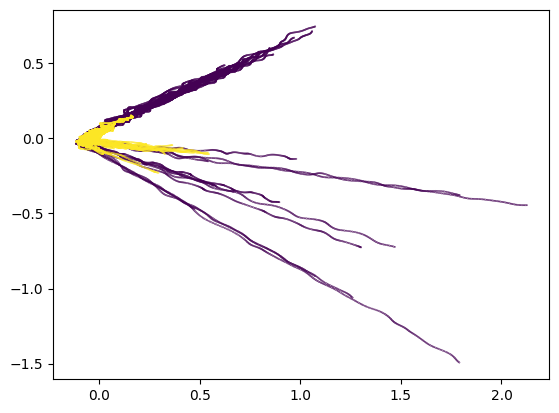

In [6]:
plt.scatter(pca[:,0], pca[:,1], s=0.1, c=xr.where(pca.cmpnd=='a01', 0, 1))

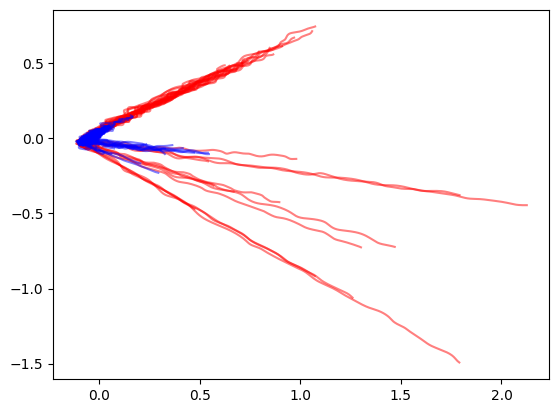

In [7]:
for lcmpnd, cmpnd in pca.groupby('cmpnd'):
    for ltraj, traj in cmpnd.groupby('trajid'):
        c = 'b' if lcmpnd == 'i01' else 'r'
        plt.plot(traj[:,0], traj[:,1], c=c, alpha=0.5)

## Now parts of homologous series

In [3]:
a02 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C3H6.nc')
a03 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C4H8_g0.nc')

In [4]:
def vis(frames, charge=0):
    mol = sh.dynamic.filter_unphysical.mol_from_atXYZ(
        frames.atXYZ.isel(frame=0), charge=charge, to2D=True
    )
    for atom in mol.GetAtoms():
        atom.SetProp("atomNote", str(atom.GetIdx()))
    return mol

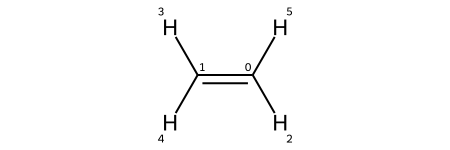

In [5]:
vis(a01, 0)

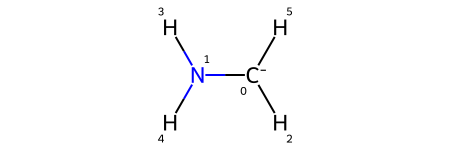

In [6]:
vis(i01, -1)

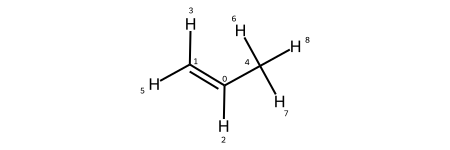

In [7]:
vis(a02)

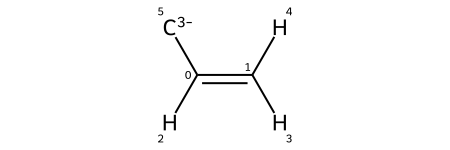

In [8]:
# Renumber: 4 <-> 5
a02new = a02.isel(atom=slice(0,6)).assign_coords(atom=[0, 1, 2, 3, 5, 4]).sortby('atom')
vis(a02new, -3)

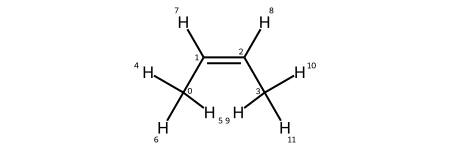

In [9]:
vis(a03)

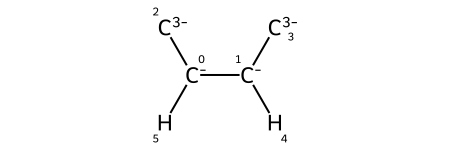

In [10]:
# Renumber: 0->3, 1->1, 2->0, 3->2, 4->4, 5->5,
a03new = a03.isel(atom=[0,1,2,3,7,8]).assign_coords(atom=[3, 1, 0, 2, 4, 5]).sortby('atom')
vis(a03new, -8)

In [11]:
homologs = xr.concat(
    [
        a01.sh.expand_midx('frame', 'cmpnd', 'a01'),
        i01.sh.expand_midx('frame', 'cmpnd', 'i01'),
        a02new.sh.expand_midx('frame', 'cmpnd', 'a02'),
        a03new.sh.expand_midx('frame', 'cmpnd', 'a03')
    ],
    dim='frame',
    coords='minimal',
    compat='override'
)
homologs

<xarray.Dataset> Size: 2GB
Dimensions:    (state: 3, frame: 151874, direction: 3, statecomb: 3, atom: 6,
                trajid_: 555, state2: 3)
Coordinates: (12/13)
  * state      (state) int64 24B 1 2 3
  * state2     (state2) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
  * trajid_    (trajid_) int32 2kB 2 3 4 6 8 9 10 ... 955 956 957 961 962 969
  * statecomb  (statecomb) object 24B MultiIndex
    ...         ...
  * to         (statecomb) int64 24B 2 3 3
  * frame      (frame) object 1MB MultiIndex
  * cmpnd      (frame) object 1MB 'a01' 'a01' 'a01' 'a01' ... 'a03' 'a03' 'a03'
  * trajid     (frame) int64 1MB 2 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 1MB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
    atNames    (atom) <U1 24B 'C' 'C' 'H' 'H' 'H' 'H'
Data variables: (12/13)
    energy     (state, frame) float64 4MB 0.8285 0.6196 0.3822 ... 15.66 15.52
    e_kin      (frame) float64 1MB 0.1839 0.4249 0.7293 ... 6.936 7.527 8.137
    dip_perm   (state, direction, frame) float64 11MB 0.005891 ... -0.01176
    dip_trans  (statecomb, direction, frame) float64 11MB -1.421 ... 0.7723
    sdiag      (frame) int64 1MB 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1 1
    astate     (frame) int64 1MB 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1 1
    ...         ...
    phases     (state, frame) float64 4MB -1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    nacs       (statecomb, atom, direction, frame) float64 66MB -0.2649 ... -...
    atXYZ      (atom, direction, frame) float64 22MB 0.003451 ... -1.382
    max_ts     (frame, trajid_) float64 674MB 400.0 400.0 400.0 ... nan nan nan
    completed  (frame, trajid_) float32 337MB 1.0 1.0 1.0 nan ... nan nan nan
    nsteps     (frame, trajid_) float64 674MB 401.0 401.0 401.0 ... nan nan nan
Attributes:
    delta_t:  0.5

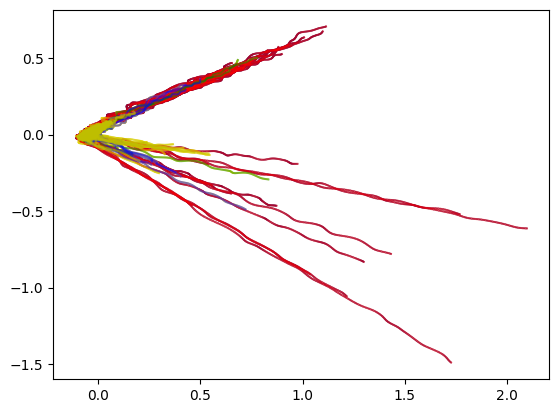

In [17]:
pwdist = homologs.atXYZ.sh.subtract_combinations('atom').sh.norm('direction')
pca = pwdist.sh.pca('atomcomb')
plt.scatter(pca[:,0], pca[:,1], s=0.1, c=xr.where(pca.cmpnd=='a01', 0, 1))
for lcmpnd, cmpnd in pca.groupby('cmpnd'):
    for ltraj, traj in cmpnd.groupby('trajid'):
        c = {
            'a01': 'r', 
            'a02': 'g', 
            'a03': 'b', 
            'i01': 'y', 
        }[lcmpnd]
        plt.plot(traj[:,0], traj[:,1], c=c, alpha=0.5)

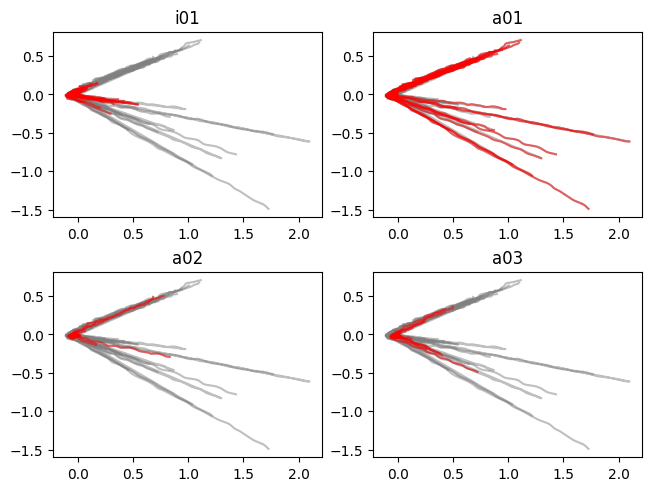

In [18]:
fig, axs = plt.subplot_mosaic([['i01', 'a01'],['a02', 'a03']], layout='constrained')

# grey background
for ax in axs.values():
    for _, traj in pca.groupby('trajid'):
        ax.plot(traj[:,0], traj[:,1], c='gray', alpha=0.5)

for name, cmpnd in pca.groupby('cmpnd'):
    ax = axs[name]
    for _, traj in cmpnd.groupby('trajid'):
        ax.plot(traj[:,0], traj[:,1], c='red', alpha=0.5)
    ax.set_title(name)


### Filter by PCA-adventurousness

In [19]:
fpca = sh.xrhelpers.flatten_levels(pca, 'frame', ['cmpnd', 'trajid'])
fpca

<xarray.DataArray (frame: 151874, PC: 2)> Size: 2MB
array([[-0.062883  , -0.00384595],
       [-0.0620098 , -0.00371305],
       [-0.06050289, -0.00385374],
       ...,
       [-0.01327303, -0.0261533 ],
       [-0.01487247, -0.02496546],
       [-0.01664111, -0.02353462]], shape=(151874, 2))
Coordinates:
  * frame    (frame) object 1MB MultiIndex
  * trajid   (frame) object 1MB ('a01', 2) ('a01', 2) ... ('a03', 316)
  * time     (frame) float64 1MB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
Dimensions without coordinates: PC

In [20]:
adventurousness = fpca.sh.norm('PC').groupby('trajid').max()
upca = fpca.sh.sel_trajids(adventurousness[adventurousness < 0.2].trajid)
upca

<xarray.DataArray (frame: 129412, PC: 2)> Size: 2MB
array([[-0.062883  , -0.00384595],
       [-0.0620098 , -0.00371305],
       [-0.06050289, -0.00385374],
       ...,
       [-0.01327303, -0.0261533 ],
       [-0.01487247, -0.02496546],
       [-0.01664111, -0.02353462]], shape=(129412, 2))
Coordinates:
  * frame    (frame) object 1MB MultiIndex
  * trajid   (frame) object 1MB ('a01', 2) ('a01', 2) ... ('a03', 316)
  * time     (frame) float64 1MB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
Dimensions without coordinates: PC

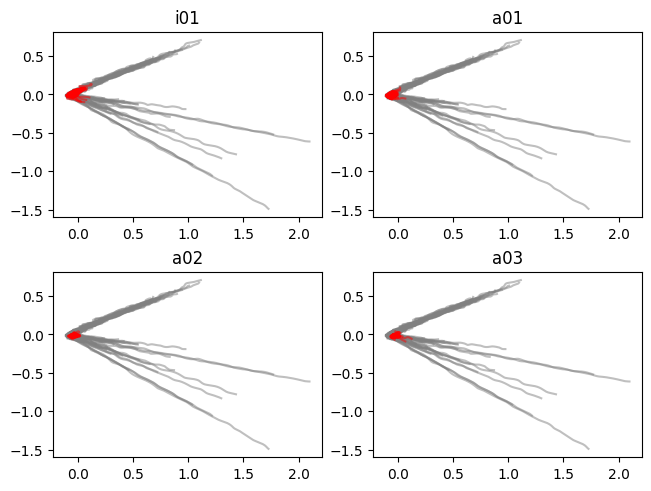

In [21]:
fig, axs = plt.subplot_mosaic([['i01', 'a01'],['a02', 'a03']], layout='constrained')

for name, ax in axs.items():
    ax.set_title(name)
    for (cmpnd, trajid), traj in fpca.groupby('trajid'):
        ax.plot(traj[:,0], traj[:,1], c='gray', alpha=0.5)

for (cmpnd, trajid), traj in upca.groupby('trajid'):
        axs[cmpnd].plot(traj[:,0], traj[:,1], c='r', alpha=0.5)

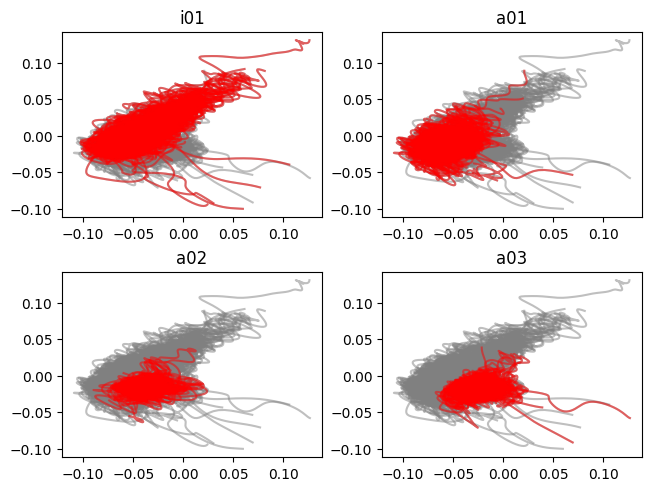

In [22]:
fig, axs = plt.subplot_mosaic([['i01', 'a01'],['a02', 'a03']], layout='constrained')

for name, ax in axs.items():
    ax.set_title(name)
    for (cmpnd, trajid), traj in upca.groupby('trajid'):
        ax.plot(traj[:,0], traj[:,1], c='gray', alpha=0.5)

for (cmpnd, trajid), traj in upca.groupby('trajid'):
        axs[cmpnd].plot(traj[:,0], traj[:,1], c='r', alpha=0.5)

## Changes over time

In [14]:
homologs.sh.get_inter_state().energy.sh.time_grouped_ci()

<xarray.Dataset> Size: 32kB
Dimensions:    (time: 400, statecomb: 3)
Coordinates:
  * statecomb  (statecomb) <U11 132B '$S_1 - S_0$' '$S_2 - S_0$' '$S_2 - S_1$'
  * time       (time) float64 3kB 0.0 0.5 1.0 1.5 ... 198.0 198.5 199.0 199.5
Data variables:
    lower      (time, statecomb) float64 10kB 8.816 12.73 3.901 ... 5.466 3.466
    upper      (time, statecomb) float64 10kB 8.901 13.0 4.108 ... 6.896 4.184
    mean       (time, statecomb) float64 10kB 8.858 12.86 4.004 ... 6.181 3.825

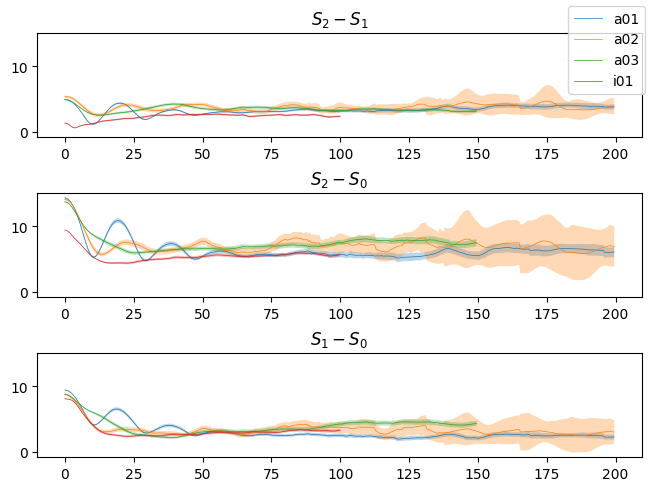

In [ ]:
ise = homologs.sh.get_inter_state().energy
fig, axs = plt.subplot_mosaic(
    ise.statecomb.values[::-1, None], layout='constrained', sharey=True
)
for lcmpnd, cmpnd in ise.groupby('cmpnd'):
    ci = cmpnd.sh.time_grouped_ci()
    label = lcmpnd
    for lsc, sc in ci.groupby('statecomb'):
        sc = sc.squeeze('statecomb')
        ax = axs[lsc]
        ax.set_title(lsc)
        ax.plot('time', 'mean', data=sc, lw=0.5, label=label)
        label = '' # To avoid duplicate labels in the legend
        ax.fill_between('time', 'upper', 'lower', data=sc, alpha=0.3)

# for ax in axs.values():
#     ax.legend()
fig.legend()

Text(0, 0.5, 'Population')

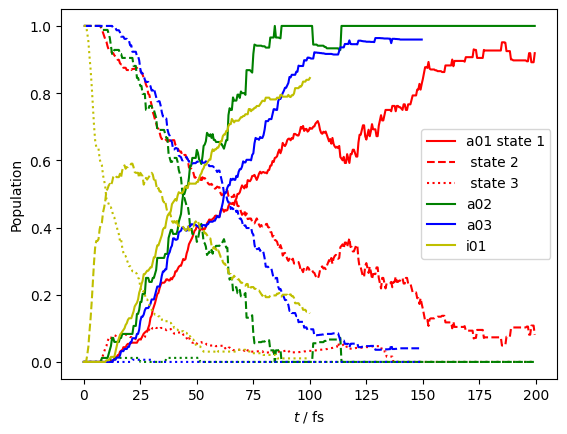

In [28]:
label_ls = True
for lcmpnd, cmpnd in homologs.groupby('cmpnd'):
    pops = cmpnd.sh.calc_pops()
    c = {
            'a01': 'r', 
            'a02': 'g', 
            'a03': 'b', 
            'i01': 'y', 
    }[lcmpnd]
    label = lcmpnd
    for lstate, state in pops.groupby('state'):
        ls = {1: '-', 2: '--', 3: ':'}[lstate]
        if label_ls:
            label += f' state {lstate}'
        plt.plot(state['time'], state, c=c, ls=ls, label=label)
        label=''
    label_ls = False

plt.legend()
plt.xlabel('$t$ / fs')
plt.ylabel('Population')

# Dihedrals

In [29]:
a01.atXYZ.attrs['smiles_map'] = a01.atXYZ.isel(frame=0).sh.smiles_map()
i01.atXYZ.attrs['smiles_map'] = i01.atXYZ.isel(frame=0).sh.smiles_map(charge=-1)
a02new.atXYZ.attrs['smiles_map'] = a02new.atXYZ.isel(frame=0).sh.smiles_map(charge=-3)
a03new.atXYZ.attrs['smiles_map'] = a03new.atXYZ.isel(frame=0).sh.smiles_map(charge=-8)

Found following C-C bonds:


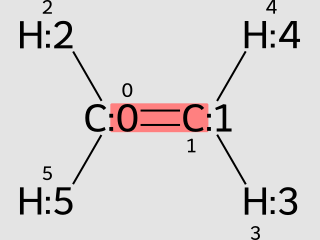

Remove 28 trajectories (9951 frames) containing C-C cleavage
with IDs: [775 126 770 353 318 933 260 962 187 312 246 702 258 299 896 303 420  29
 132 605 836 362 726 180 703 470 292 192]
Found following C-H bonds:


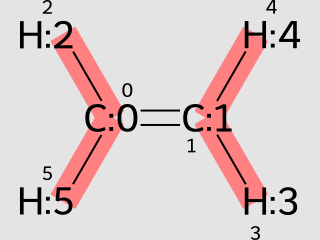

Remove 179 trajectories (37183 frames) containing C-H cleavage
with IDs: [307 361  19 541 651 886 839 139 135 176 242 549 824  20 656 711 647 710
 939 378 667 588 206 883 618 492   4 417 592 294  32 889 241 366 773 938
 837 539 780 934 198 951  73 957 358 670 372 349 956 188 489 181 175 236
 490 602  70 377 473 776 771 373 872 890 410 900 947 538 834 728  62 480
 729  85 485 590 487 359 876 257  77 472  90 718 830 550 421  86 208 178
 950 527 535 709 190 267 707 247 772 620 477 898 877 663 653 537 888 778
 408  74  11  16 375 675 138 832 871 262 250 297 369 467 759 762 422 291
 243 308  71  10 892 494 406 666 902 238 295  72 240 367 315 432 306  69
 427 946  81 251 611  64 416 818 542 784 256   3 183 525 655  15 874 665
  83 945 701 424 828 304 534 415 716   8  22 351 311 370  79 603  88]
Keep 90 trajectories (14897 frames)
Found following C-H bonds:


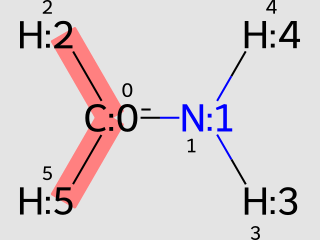

Remove 55 trajectories (10931 frames) containing C-H cleavage
with IDs: [793 845 327 785 929 278 268 877  31 337 771 123 332 802 325 502  65 321
 146 728 390 205 628 858 175 599 424 124  32 393 126 701 314 343  25 524
 827 872 315  29  60 687 589 518 133 753 812 313 938 791 766 620 235 211
 545]
Keep 145 trajectories (28434 frames)
Found following C-C bonds:


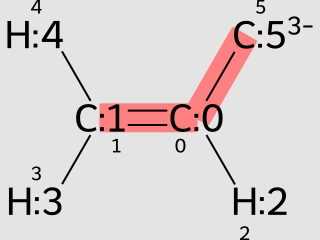

Remove 3 trajectories (1062 frames) containing C-C cleavage
with IDs: [824 407 127]
Found following C-H bonds:


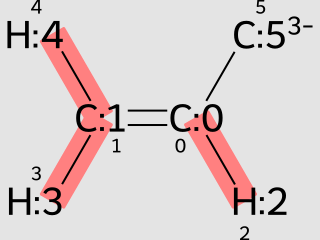

Remove 45 trajectories (7487 frames) containing C-H cleavage
with IDs: [672 954 938 317 179 583 471 392 388 756 536 281  82 472 607 716 565 670
 226 312   8 499 680 364 933 930 422 438 451  53 257 825 955 164 219 318
 284 768  33 342 160 857 751 315 533]
Keep 36 trajectories (5350 frames)
Found following C-C bonds:


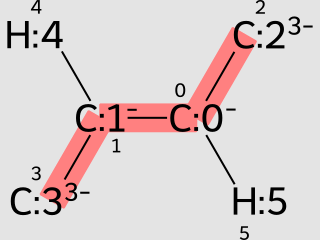

Remove 13 trajectories (3900 frames) containing C-C cleavage
with IDs: [233 206  19 270 260 288  68 310  77 151 274  64  61]
Found following C-H bonds:


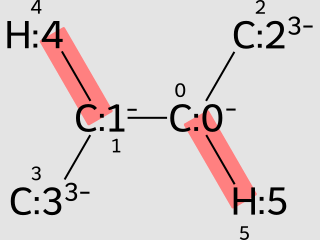

Remove 22 trajectories (5429 frames) containing C-H cleavage
with IDs: [129 142  82  97  11  78  52 190 161 162 217 191 179 177 314  59   2  22
 247  42  56 239]
Keep 121 trajectories (27250 frames)


In [32]:
nca01 = sh.dynamic.filter_unphysical.filter_cleavage(a01, CC=True, CH=True)
nci01 = sh.dynamic.filter_unphysical.filter_cleavage(i01, CC=False, CH=True)
nca02 = sh.dynamic.filter_unphysical.filter_cleavage(a02new, CC=True, CH=True)
nca03 = sh.dynamic.filter_unphysical.filter_cleavage(a03new, CC=True, CH=True)

In [33]:

nchomologs = xr.concat(
    [
        nca01.sh.expand_midx('frame', 'cmpnd', 'a01'),
        nci01.sh.expand_midx('frame', 'cmpnd', 'i01'),
        nca02.sh.expand_midx('frame', 'cmpnd', 'a02'),
        nca03.sh.expand_midx('frame', 'cmpnd', 'a03')
    ],
    dim='frame',
    coords='minimal',
    compat='override'
)
nchomologs

<xarray.Dataset> Size: 606MB
Dimensions:    (state: 3, frame: 75931, direction: 3, statecomb: 3, atom: 6,
                trajid_: 336, state2: 3)
Coordinates: (12/13)
  * state      (state) int64 24B 1 2 3
  * state2     (state2) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
  * trajid_    (trajid_) int32 1kB 2 3 6 9 13 16 17 ... 932 943 944 947 961 969
  * statecomb  (statecomb) object 24B MultiIndex
    ...         ...
  * to         (statecomb) int64 24B 2 3 3
  * frame      (frame) object 607kB MultiIndex
  * cmpnd      (frame) object 607kB 'a01' 'a01' 'a01' ... 'a03' 'a03' 'a03'
  * trajid     (frame) int64 607kB 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 607kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
    atNames    (atom) <U1 24B 'C' 'C' 'H' 'H' 'H' 'H'
Data variables: (12/13)
    energy     (state, frame) float64 2MB 0.8285 0.6196 0.3822 ... 15.66 15.52
    e_kin      (frame) float64 607kB 0.1839 0.4249 0.7293 ... 6.936 7.527 8.137
    dip_perm   (state, direction, frame) float64 5MB 0.005891 ... -0.01176
    dip_trans  (statecomb, direction, frame) float64 5MB -1.421 ... 0.7723
    sdiag      (frame) int64 607kB 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1
    astate     (frame) int64 607kB 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1
    ...         ...
    phases     (state, frame) float64 2MB -1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    nacs       (statecomb, atom, direction, frame) float64 33MB -0.2649 ... -...
    atXYZ      (atom, direction, frame) float64 11MB 0.003451 ... -1.382
    max_ts     (frame, trajid_) float64 204MB 400.0 nan nan nan ... nan nan nan
    completed  (frame, trajid_) float32 102MB 1.0 nan nan nan ... nan nan nan
    nsteps     (frame, trajid_) float64 204MB 401.0 nan nan nan ... nan nan nan
Attributes:
    delta_t:  0.5

In [34]:
fdihs = nchomologs.atXYZ.sh.dihedral(2, 0, 1, 3, full=True)

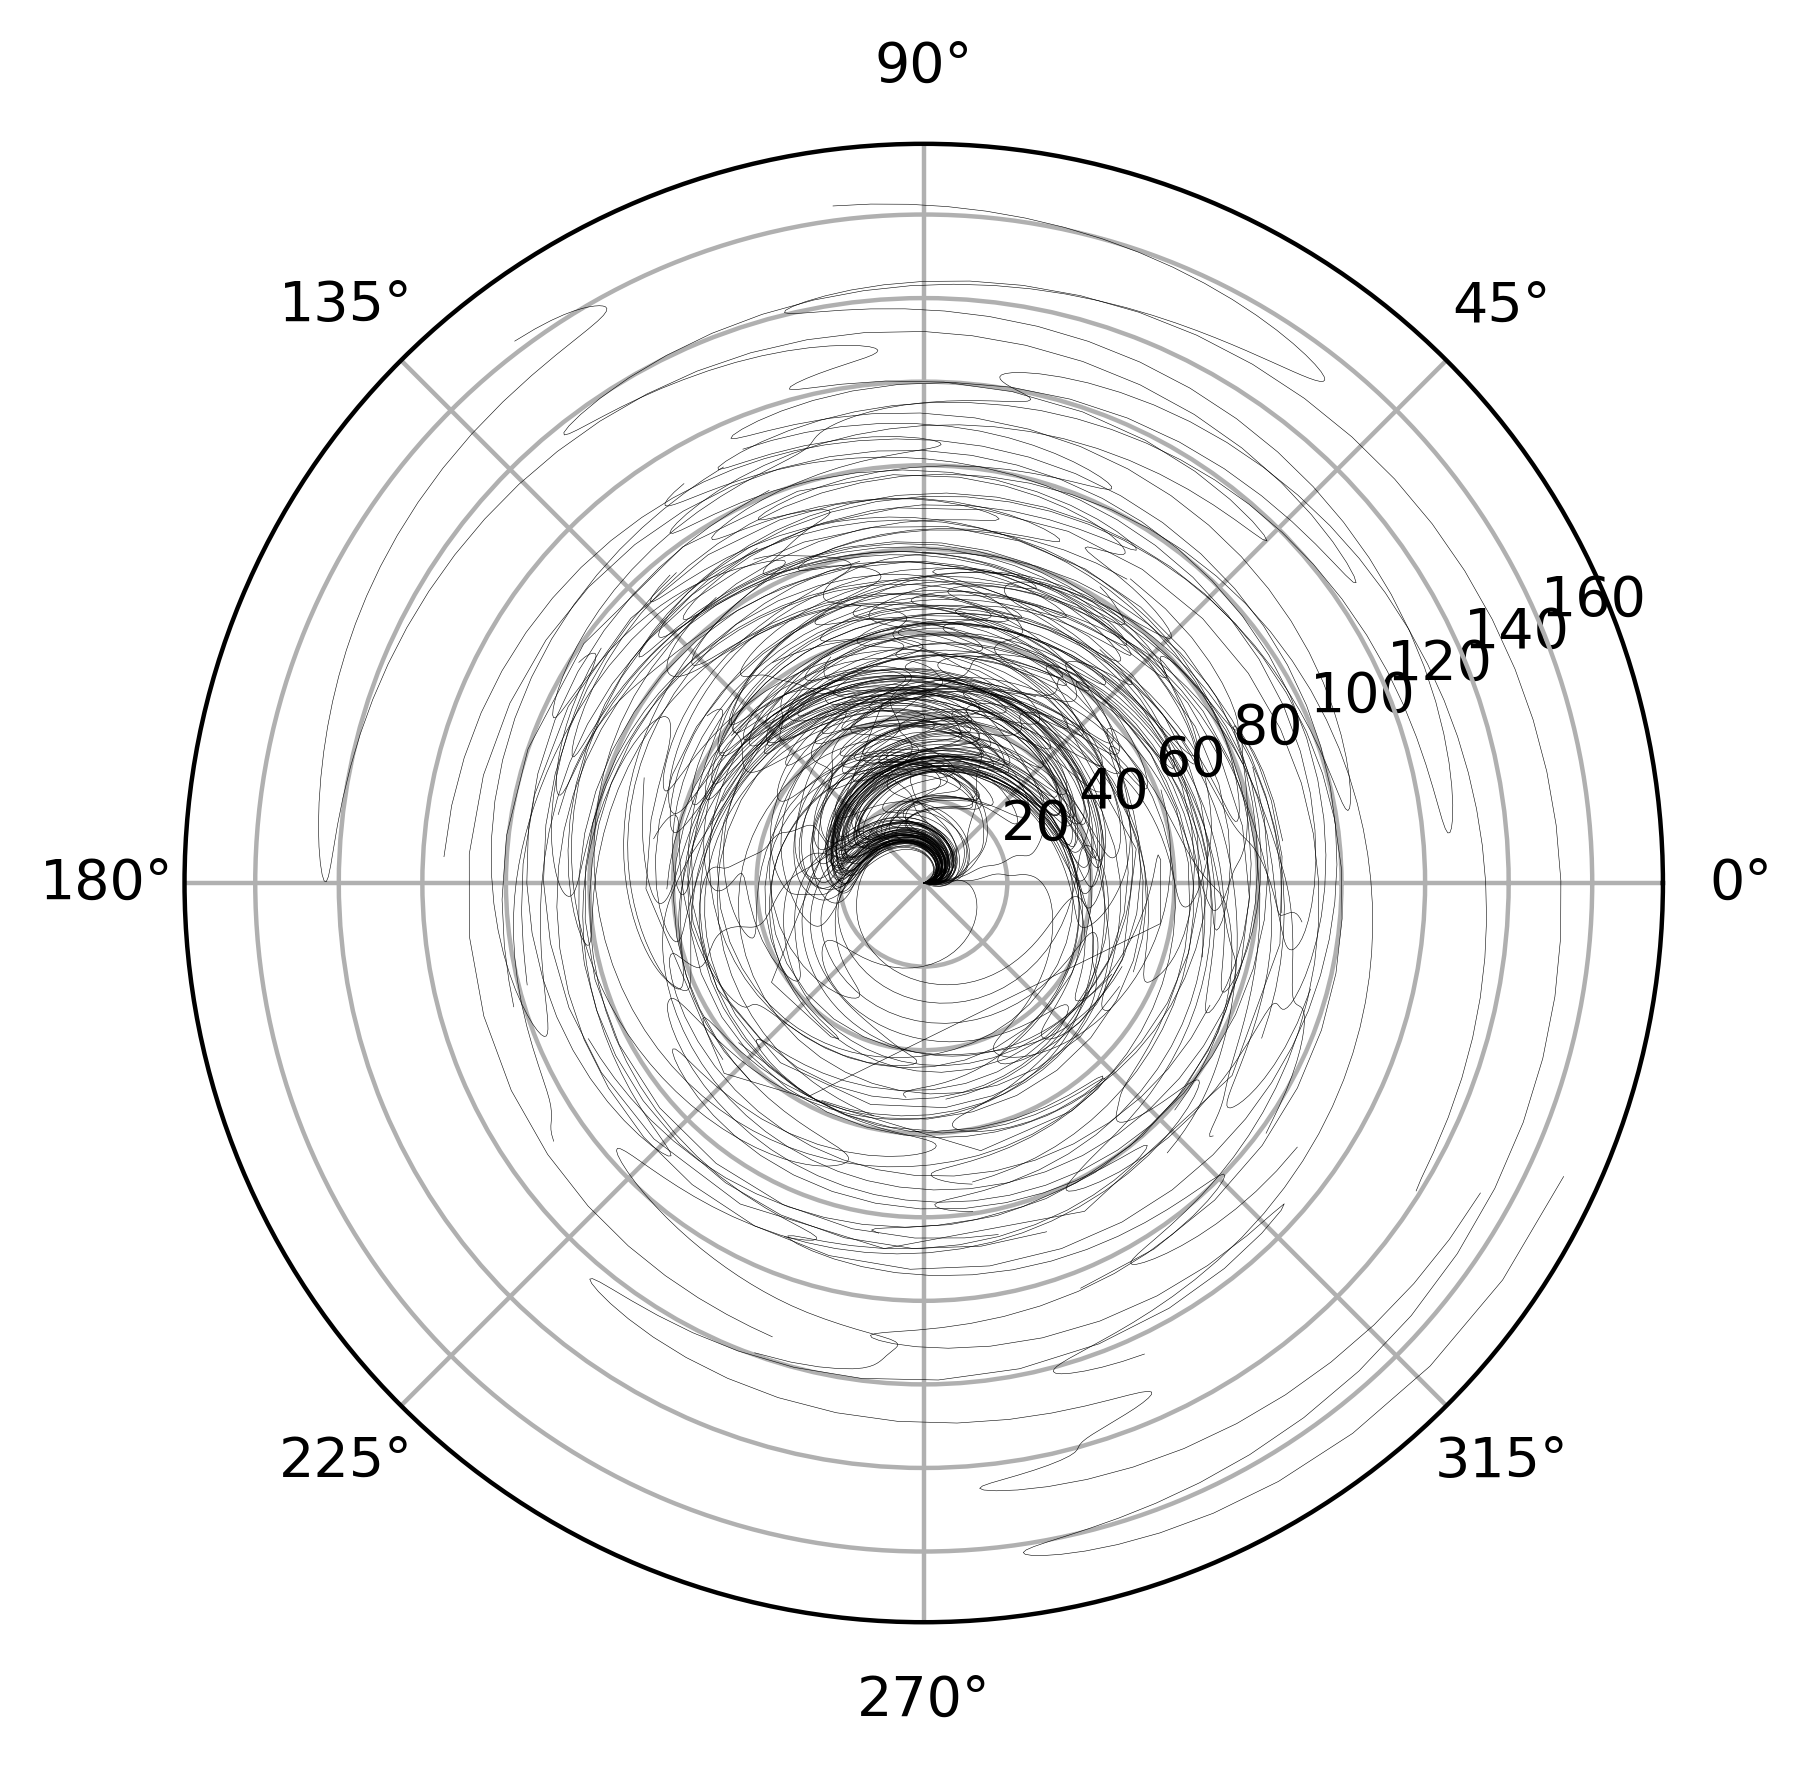

In [49]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': 'polar'}, dpi=400)
for lcmpnd, cmpnd in fdihs.groupby('cmpnd'):
    c = {
            'a01': 'r', 
            'a02': 'g', 
            'a03': 'b', 
            'i01': 'y', 
    }[lcmpnd]
    for ltraj, traj in cmpnd.groupby('trajid'):
        c = 'b' if traj.sel(time = 7) < 0 else 'r'
        ax.plot(
            traj if c=='r' else -traj,
            traj.time, c='k', lw=0.1
        )
    break

# Identify clusters
Over all homologs/isoelectronics

## 1. On the frame level

### 1.1 $k$-means on frames before PCA

In [19]:
from sklearn.cluster import KMeans

In [20]:
pwdist

<xarray.DataArray (atomcomb: 15, frame: 151874)> Size: 18MB
array([[1.34517946, 1.35167321, 1.35899658, ..., 1.63342424, 1.64030952,
        1.64714128],
       [1.13050448, 1.11766826, 1.10153534, ..., 2.77850595, 2.78378724,
        2.78811195],
       [1.97807253, 2.00833229, 2.0540353 , ..., 4.26498798, 4.27521619,
        4.28428109],
       ...,
       [1.80253552, 1.82526038, 1.85919207, ..., 3.028167  , 3.02042213,
        3.00846061],
       [2.86438682, 2.88767066, 2.93184765, ..., 2.61336497, 2.52433086,
        2.42590175],
       [2.33257396, 2.33677163, 2.34617471, ..., 3.09194364, 3.04189055,
        2.98573338]], shape=(15, 151874))
Coordinates:
  * frame    (frame) object 1MB MultiIndex
  * cmpnd    (frame) object 1MB 'a01' 'a01' 'a01' 'a01' ... 'a03' 'a03' 'a03'
  * trajid   (frame) int64 1MB 2 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time     (frame) float64 1MB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
Dimensions without coordinates: atomcomb

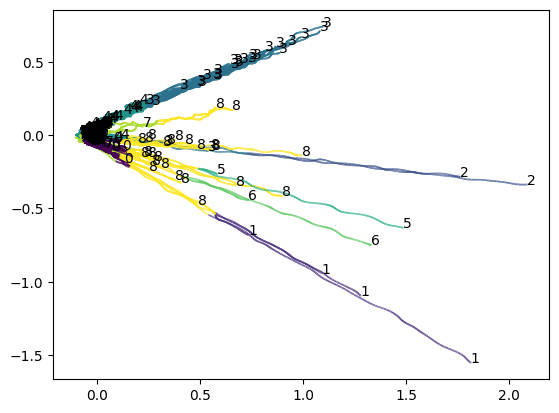

In [21]:
kmc = KMeans(n_clusters=9)
pwdist = pwdist.transpose('frame', 'atomcomb')
kmc.fit(pwdist)
res_kmc = kmc.predict(pwdist)
pca['cluster'] = 'frame', res_kmc

plt.scatter(pca[:,0], pca[:,1], c=res_kmc, s=0.1)
for lcmpnd, cmpnd in pca.groupby('cmpnd'):
    for ltraj, traj in cmpnd.groupby('trajid'):
        point = traj.isel(frame=-1)
        plt.text(point.item(0), point.item(1), point.cluster.item())

### 1.2. $k$-means on frames _after_ PCA

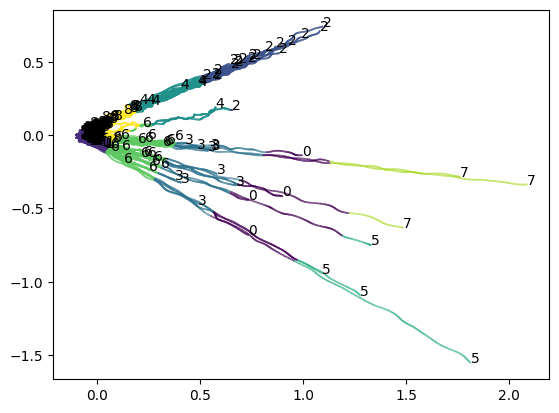

In [22]:
kmc = KMeans(n_clusters=9)
res_kmc = kmc.fit(pca).predict(pca)
pca['cluster'] = 'frame', res_kmc
plt.scatter(pca[:, 0], pca[:, 1], c=res_kmc, s=0.1)
for lcmpnd, cmpnd in pca.groupby('cmpnd'):
    for ltraj, traj in cmpnd.groupby('trajid'):
        point = traj.isel(frame=-1)
        plt.text(point.item(0), point.item(1), point.cluster.item())

### 1.3 Other clustering methods on frames
(Takes ages, non-viable)

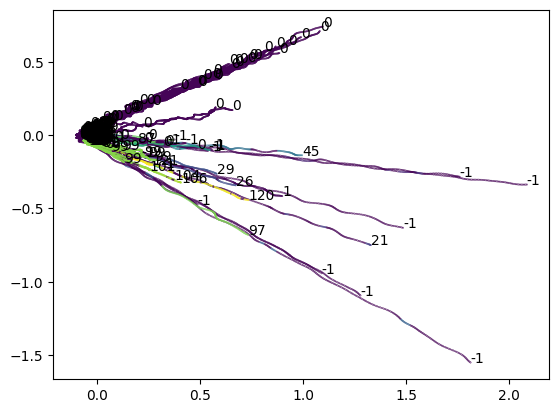

In [254]:
# from sklearn.cluster import DBSCAN
# res_sc = DBSCAN().fit_predict(pwdist)
# pca['cluster'] = 'frame', res_sc
# plt.scatter(pca[:, 0], pca[:, 1], c=res_sc, s=0.1)
# for lcmpnd, cmpnd in pca.groupby('cmpnd'):
#     for ltraj, traj in cmpnd.groupby('trajid'):
#         point = traj.isel(frame=-1)
#         plt.text(point.item(0), point.item(1), point.cluster.item())

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# res_sc = AgglomerativeClustering().fit_predict(pwdist)
# pca['cluster'] = 'frame', res_sc
# plt.scatter(pca[:, 0], pca[:, 1], c=res_sc, s=0.1)
# for lcmpnd, cmpnd in pca.groupby('cmpnd'):
#     for ltraj, traj in cmpnd.groupby('trajid'):
#         point = traj.isel(frame=-1)
#         plt.text(point.item(0), point.item(1), point.cluster.item())

## 2. On the trajectory level

### 2.1 Cluster trajectories by final frame

### 2.2 Cluster trajectories by final frame _after_ PCA

In [44]:
kmc = KMeans(n_clusters=7)
pca_final_frames = (
    pca
    .groupby('cmpnd').map(
        lambda cmpnd: cmpnd.groupby('trajid').map(
            lambda traj: traj.isel(frame=-1)
        )
    )
    .stack(traj=['cmpnd', 'trajid'])
    .dropna('traj', how='all')
    .transpose('traj', 'PC')
)
pca_final_frames

<xarray.DataArray (traj: 737, PC: 2)> Size: 12kB
array([[-0.03711216,  0.005575  ],
       [-0.0764319 , -0.01585773],
       [-0.07849543,  0.00317787],
       ...,
       [ 0.37589433, -0.03091471],
       [-0.02752633,  0.00978607],
       [-0.02413813,  0.0022183 ]], shape=(737, 2))
Coordinates:
    frame    (traj) object 6kB ('a01', np.int64(2), np.float64(83.5)) ... ('i...
    time     (traj) float64 6kB 83.5 109.0 94.0 199.5 ... 100.0 100.0 100.0
    cluster  (traj) float64 6kB 1.0 1.0 1.0 0.0 1.0 1.0 ... 1.0 1.0 6.0 1.0 1.0
  * traj     (traj) object 6kB MultiIndex
  * cmpnd    (traj) object 6kB 'a01' 'a01' 'a01' 'a01' ... 'i01' 'i01' 'i01'
  * trajid   (traj) int64 6kB 2 3 4 8 10 11 15 ... 919 920 924 929 938 943 947
Dimensions without coordinates: PC

In [43]:
# Better approach?

# (
#     pca
#     .reset_index('frame')
#     .assign_coords(
#         trajid=pca
#             .indexes['frame']
#             .map(lambda x: '_'.join([x[0], str(x[1])]))
#     )
#     .drop_vars('cmpnd')
# )

In [45]:
res_kmc = kmc.fit(pca_final_frames).predict(pca_final_frames)
res_kmc = pca_final_frames.isel(PC=0).copy(data=res_kmc)
res_kmc

<xarray.DataArray (traj: 737)> Size: 3kB
array([0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 6, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 6, 0, 0, 0, 0, 1, 0, 1, 4, 0, 0, 0, 0, 2, 1, 0, 0, 3, 0, 0,
       2, 3, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0], dtype=int32)
Coordinates:
    frame    (traj) object 6kB ('a01', np.int64(2), np.float64(83.5)) ... ('i...
    time     (traj) float64 6kB 83.5 109.0 94.0 199.5 ... 100.0 100.0 100.0
    cluster  (traj) float64 6kB 1.0 1.0 1.0 0.0 1.0 1.0 ... 1.0 1.0 6.0 1.0 1.0
  * traj     (traj) object 6kB MultiIndex
  * cmpnd    (traj) object 6kB 'a01' 'a01' 'a01' 'a01' ... 'i01' 'i01' 'i01'
  * trajid   (traj) int64 6kB 2 3 4 8 10 11 15 ... 919 920 924 929 938 943 947

In [ ]:
pca['cluster'] = 'frame', res_kmc
plt.scatter(pca[:, 0], pca[:, 1], c=res_kmc, s=0.1)
for lcmpnd, cmpnd in pca.groupby('cmpnd'):
    for ltraj, traj in cmpnd.groupby('trajid'):
        point = traj.isel(frame=-1)
        plt.text(point.item(0), point.item(1), point.cluster.item())

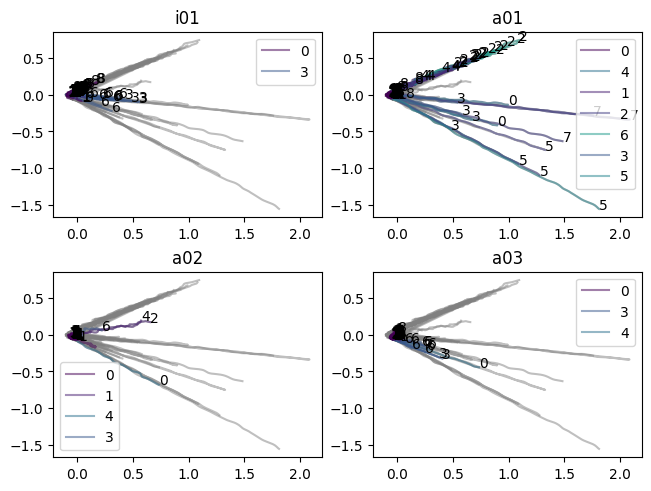

In [50]:
cmap = plt.get_cmap('viridis').resampled(12).colors
fig, axs = plt.subplot_mosaic([['i01', 'a01'],['a02', 'a03']], layout='constrained')

# grey background
for ax in axs.values():
    for _, traj in pca.groupby('trajid'):
        ax.plot(traj[:,0], traj[:,1], c='gray', alpha=0.5)

for name, cmpnd in pca.groupby('cmpnd'):
    seen_clusters = []
    ax = axs[name]
    for trajid, traj in cmpnd.groupby('trajid'):
        cluster = res_kmc.sel(cmpnd=name, trajid=trajid).item()
        c = cmap[cluster]
        ax.plot(traj[:,0], traj[:,1], c=c, alpha=0.5, label='' if cluster in seen_clusters else cluster)
        seen_clusters.append(cluster)
        point = traj.isel(frame=-1)
        ax.text(point.item(0), point.item(1), point.cluster.item()) # WRONG!
    ax.set_title(name)
    ax.legend()

In [ ]:
for trajid, traj in pca.groupby('trajid'):
    print(trajid, traj.cmpnd)
    break
    plt.scatter(pca[:, 0], pca[:, 1], c=res_kmc, s=0.1)

2 <xarray.DataArray 'cmpnd' (frame: 669)> Size: 5kB
array(['a01', 'a01', 'a01', ..., 'a03', 'a03', 'a03'],
      shape=(669,), dtype=object)
Coordinates:
  * frame    (frame) object 5kB MultiIndex
  * cmpnd    (frame) object 5kB 'a01' 'a01' 'a01' 'a01' ... 'a03' 'a03' 'a03'
  * trajid   (frame) int64 5kB 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2
  * time     (frame) float64 5kB 0.0 0.5 1.0 1.5 2.0 ... 148.0 148.5 149.0 149.5


### (Previous work)

In [241]:
upwdist = pwdist.unstack('frame').stack(traj=['cmpnd', 'trajid']).stack(special=['time', 'atomcomb']).dropna('traj', how='all')
upwdist

<xarray.DataArray (traj: 737, special: 6000)> Size: 35MB
array([[1.34517946, 1.13050448, 1.97807253, ...,        nan,        nan,
               nan],
       [1.37408323, 1.06384448, 2.07657152, ...,        nan,        nan,
               nan],
       [1.34937315, 1.18426761, 2.25860469, ...,        nan,        nan,
               nan],
       ...,
       [1.27282081, 1.14685435, 2.09882467, ...,        nan,        nan,
               nan],
       [1.28640156, 0.96443997, 2.05116248, ...,        nan,        nan,
               nan],
       [1.29442238, 1.02194666, 1.95637947, ...,        nan,        nan,
               nan]], shape=(737, 6000))
Coordinates:
  * traj      (traj) object 6kB MultiIndex
  * cmpnd     (traj) object 6kB 'a01' 'a01' 'a01' 'a01' ... 'i01' 'i01' 'i01'
  * trajid    (traj) int64 6kB 2 3 4 8 10 11 15 ... 919 920 924 929 938 943 947
  * special   (special) object 48kB MultiIndex
  * time      (special) float64 48kB 0.0 0.0 0.0 0.0 ... 199.5 199.5 199.5 199.5
  * atomcomb  (special) int64 48kB 0 1 2 3 4 5 6 7 8 ... 6 7 8 9 10 11 12 13 14

In [242]:
dupwdist = upwdist.dropna('special', how='any')#.dropna('traj', how='any'))
dupwdist

<xarray.DataArray (traj: 737, special: 690)> Size: 4MB
array([[1.34517946, 1.13050448, 1.97807253, ..., 1.88585848, 2.14066664,
        3.04526073],
       [1.37408323, 1.06384448, 2.07657152, ..., 1.85200159, 2.06164851,
        2.50848262],
       [1.34937315, 1.18426761, 2.25860469, ..., 1.68662071, 2.71205706,
        3.13871697],
       ...,
       [1.27282081, 1.14685435, 2.09882467, ..., 1.68744411, 2.70886764,
        2.87221451],
       [1.28640156, 0.96443997, 2.05116248, ..., 1.6848211 , 3.28561369,
        2.9436839 ],
       [1.29442238, 1.02194666, 1.95637947, ..., 1.78653938, 1.96595801,
        2.8728819 ]], shape=(737, 690))
Coordinates:
  * traj      (traj) object 6kB MultiIndex
  * cmpnd     (traj) object 6kB 'a01' 'a01' 'a01' 'a01' ... 'i01' 'i01' 'i01'
  * trajid    (traj) int64 6kB 2 3 4 8 10 11 15 ... 919 920 924 929 938 943 947
  * special   (special) object 6kB MultiIndex
  * time      (special) float64 6kB 0.0 0.0 0.0 0.0 0.0 ... 22.5 22.5 22.5 22.5
  * atomcomb  (special) int64 6kB 0 1 2 3 4 5 6 7 8 9 ... 6 7 8 9 10 11 12 13 14

In [143]:
dupwdist.isel(special=0)

<xarray.DataArray (traj: 737)> Size: 6kB
array([1.34517946, 1.37408323, 1.34937315, 1.36281566, 1.40071457,
       1.3189058 , 1.34020843, 1.33810126, 1.35156452, 1.36058317,
       1.34584214, 1.42053362, 1.3468481 , 1.3482966 , 1.30998848,
       1.38620935, 1.38220785, 1.36264655, 1.35903025, 1.30611288,
       1.37616017, 1.34567979, 1.32111968, 1.33938625, 1.34696048,
       1.33207181, 1.39706171, 1.39170521, 1.3787539 , 1.32485242,
       1.39206897, 1.297246  , 1.35363624, 1.3855818 , 1.32337456,
       1.27533552, 1.36181981, 1.4164345 , 1.3242795 , 1.30593974,
       1.34915811, 1.30197087, 1.37751271, 1.4358191 , 1.2850857 ,
       1.34362461, 1.3695911 , 1.32157051, 1.43009259, 1.344978  ,
       1.39441038, 1.29986855, 1.35243406, 1.36685641, 1.40889453,
       1.33533076, 1.28231811, 1.30917157, 1.37468761, 1.31504233,
       1.36153506, 1.37246829, 1.31093019, 1.3580168 , 1.32937588,
       1.40198134, 1.34244006, 1.34938169, 1.37290897, 1.37596479,
       1.33268902, 1.32915791, 1.36320229, 1.35106908, 1.36749862,
       1.3055283 , 1.36397048, 1.3671273 , 1.36826732, 1.37297889,
       1.34872379, 1.35882052, 1.4003155 , 1.37874145, 1.34691972,
       1.35385908, 1.28137296, 1.37175575, 1.30661633, 1.3276765 ,
       1.34628373, 1.33588703, 1.33543943, 1.36270801, 1.30020944,
       1.30402586, 1.33812929, 1.34960033, 1.36511408, 1.47574522,
...
       1.29764629, 1.28526551, 1.2823149 , 1.28058666, 1.28303359,
       1.29983168, 1.27402046, 1.28714727, 1.29345286, 1.27965801,
       1.28505988, 1.28229484, 1.26464766, 1.27522615, 1.2857822 ,
       1.29149409, 1.27323008, 1.28543491, 1.27675509, 1.29105936,
       1.27891889, 1.2917051 , 1.29197476, 1.29007267, 1.28908522,
       1.28942516, 1.2871922 , 1.28389918, 1.27761081, 1.27989764,
       1.2889796 , 1.27659538, 1.27997882, 1.29024472, 1.28590552,
       1.28100034, 1.29364672, 1.28523902, 1.2837565 , 1.27040115,
       1.29619405, 1.2833522 , 1.27787134, 1.27547227, 1.29183996,
       1.28707645, 1.28507859, 1.29222488, 1.29218504, 1.28901145,
       1.27384831, 1.28196494, 1.29768062, 1.27759155, 1.28355941,
       1.28305644, 1.26291622, 1.28908824, 1.28831956, 1.28509849,
       1.28966989, 1.27861435, 1.28192756, 1.29329776, 1.30039833,
       1.29909203, 1.26883739, 1.28947303, 1.30218267, 1.28033262,
       1.28389554, 1.28411892, 1.28257886, 1.29692253, 1.27007854,
       1.27793687, 1.29316865, 1.28476545, 1.29485565, 1.31022116,
       1.27200925, 1.29527885, 1.28429652, 1.28535278, 1.29146687,
       1.29777333, 1.27642325, 1.28565058, 1.28313074, 1.28355553,
       1.27281769, 1.28533065, 1.28212998, 1.27741855, 1.27282081,
       1.28640156, 1.29442238])
Coordinates:
  * traj      (traj) object 6kB MultiIndex
  * cmpnd     (traj) object 6kB 'a01' 'a01' 'a01' 'a01' ... 'i01' 'i01' 'i01'
  * trajid    (traj) int64 6kB 2 3 4 8 10 11 15 ... 919 920 924 929 938 943 947
    special   object 8B (np.float64(0.0), 0)
    time      float64 8B 0.0
    atomcomb  int64 8B 0

In [185]:
kmc = KMeans(n_clusters=10)
kmc.fit(dupwdist)
res_kmc = kmc.predict(dupwdist)
tmp = dupwdist.isel(special=0).drop_vars(['special', 'time', 'atomcomb'])
res_kmc = tmp.copy(data=res_kmc)
res_kmc

<xarray.DataArray (traj: 737)> Size: 3kB
array([0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 8, 0, 0, 0, 0,
       0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 8, 0, 0, 3, 0, 0, 0,
       0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 7, 0,
       0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 8, 0, 8,
       0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 8, 0, 0, 0, 8, 8, 0, 0, 8, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0,
       8, 0, 0, 3, 0, 3, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 5, 5, 6, 2, 2, 2, 5, 2, 5, 6,
       2, 2, 2, 2, 5, 2, 2, 2, 5, 2, 6, 5, 6, 6, 5, 5, 2, 2, 6, 6, 2, 5,
       2, 2, 2, 6, 2, 5, 2, 5, 5, 2, 5, 2, 2, 5, 6, 2, 5, 2, 5, 2, 2, 5,
       2, 2, 6, 5, 5, 5, 2, 6, 5, 2, 5, 6, 2, 2, 2, 2, 2, 5, 2, 2, 5, 2,
       2, 2, 6, 2, 2, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 4, 9, 7, 7, 7, 7, 9, 7, 4, 7, 9,
       9, 7, 7, 7, 3, 4, 7, 7, 4, 9, 7, 7, 9, 8, 3, 8, 4, 7, 7, 7, 9, 7,
       4, 4, 4, 4, 7, 0, 3, 7, 4, 7, 4, 7, 7, 4, 4, 9, 3, 7, 7, 3, 7, 4,
       7, 7, 9, 9, 7, 3, 4, 7, 7, 8, 8, 7, 4, 7, 4, 8, 9, 7, 7, 3, 3, 7,
       7, 7, 7, 4, 7, 7, 4, 7, 0, 9, 3, 7, 8, 3, 4, 7, 7, 4, 4, 9, 7, 7,
       7, 9, 4, 7, 7, 7, 4, 7, 3, 7, 4, 9, 7, 7, 4, 4, 4, 7, 7, 4, 8, 4,
       7, 7, 7, 4, 7, 9, 7, 7, 7, 7, 3, 9, 4, 8, 3, 7, 9, 9, 8, 7, 7, 4,
       7, 4, 3, 4, 7, 7, 4, 8, 9, 7, 9, 7, 7, 9, 7, 9, 4, 7, 7, 7, 4, 3,
       7, 7, 9, 4, 7, 9, 7, 7, 9, 8, 4, 9, 4, 4, 4, 7, 7, 3, 4, 7, 4, 4,
       3, 4, 4, 7, 4, 3, 7, 8, 7, 3, 7], dtype=int32)
Coordinates:
  * traj     (traj) object 6kB MultiIndex
  * cmpnd    (traj) object 6kB 'a01' 'a01' 'a01' 'a01' ... 'i01' 'i01' 'i01'
  * trajid   (traj) int64 6kB 2 3 4 8 10 11 15 ... 919 920 924 929 938 943 947

In [186]:
cmap = plt.get_cmap('tab10').colors#.resampled(12).colors

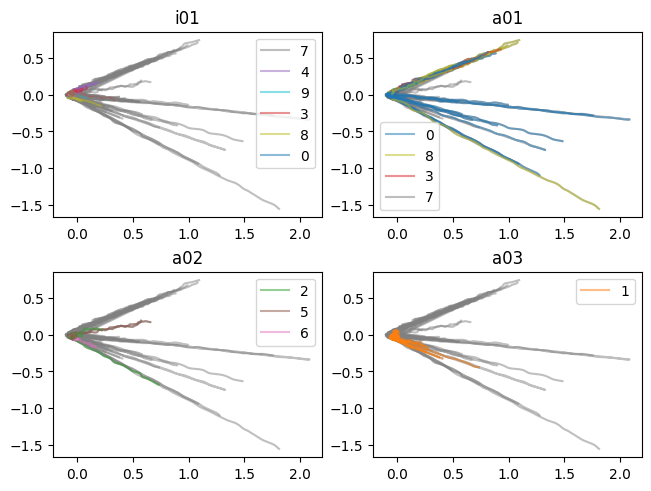

In [188]:
fig, axs = plt.subplot_mosaic([['i01', 'a01'],['a02', 'a03']], layout='constrained')

# grey background
for ax in axs.values():
    for _, traj in pca.groupby('trajid'):
        ax.plot(traj[:,0], traj[:,1], c='gray', alpha=0.5)

for name, cmpnd in pca.groupby('cmpnd'):
    seen_clusters = []
    ax = axs[name]
    for trajid, traj in cmpnd.groupby('trajid'):
        cluster = res_kmc.sel(cmpnd=name, trajid=trajid).item()
        c = cmap[cluster]
        ax.plot(traj[:,0], traj[:,1], c=c, alpha=0.5, label='' if cluster in seen_clusters else cluster)
        seen_clusters.append(cluster)
    ax.set_title(name)
    ax.legend()